# Performance Estimation of multi-class 2D Segmentation

Consider to download this Jupyter Notebook and run locally, or test it with Colab.
<br>
[![Download](https://img.shields.io/badge/Download-jupyter-blue)](https://github.com/ZerojumpLine/MOVAL/blob/main/docs/source/demos/estim_seg2d.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/ZerojumpLine/MOVAL/blob/main/docs/source/demos/estim_seg2d.ipynb)

In this notebook, we will show how to evaluate the performance of multi-class 2D segmentation tasks.
<br>
More specifically, we show an example of estimating the performance under domain shifts on Cardiac MRI segmentation (into 4 classes including background, left ventricle (LV), myocardium(MYO) and right ventricle (RV)) based on a 3D U-Net. We will utilize the calculated logits on test dataset acquired with a different scanner.
<br>
We will calculated model confidence with different confidence scores and varied calibration methods.

In [1]:
!pip install moval
!pip install seaborn
!pip install pandas
!pip install tqdm
!pip install matplotlib
!pip install nibabel

In [2]:
import os
import gdown
import itertools
import zipfile
import pandas as pd
import numpy as np
import nibabel as nib
import moval
from moval.solvers.utils import ComputMetric
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

## Load the data

In [3]:
# download the data of cardiac

output = "data_moval_supp.zip"
if not os.path.exists(output):
    url = "https://drive.google.com/u/0/uc?id=1ZlC66MGmPlf05aYYCKBaRT2q5uod8GFk&export=download"
    output = "data_moval_supp.zip"
    gdown.download(url, output, quiet=False)

directory_data = "data_moval_supp"
if not os.path.exists(directory_data):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(directory_data)

In [4]:
ls

analysis_cls.ipynb    data_moval.zip        estim_seg2d.ipynb
analysis_seg2d.ipynb  data_moval_supp/      estim_seg3d.ipynb
analysis_seg3d.ipynb  data_moval_supp.zip
data_moval/           estim_cls.ipynb


In [5]:
# now I am playing with cardiac segmentation

Datafile_eval = "data_moval_supp/Cardiacresults/seg-eval.txt"
Imglist_eval = open(Datafile_eval)
Imglist_eval_read = Imglist_eval.read().splitlines()

logits = []
gt = []
for Imgname_eval in Imglist_eval_read:
    #
    caseID = Imgname_eval.split("/")[-2]
    #
    GT_file = f"data_moval_supp/Cardiacresults/GT/1/{caseID}/seg.nii.gz"
    #
    logit_cls0_file = "data_moval_supp/Cardiacresults/cardiacval/results/pred_" + caseID + "cls0_prob.nii.gz"
    logit_cls1_file = "data_moval_supp/Cardiacresults/cardiacval/results/pred_" + caseID + "cls1_prob.nii.gz"
    logit_cls2_file = "data_moval_supp/Cardiacresults/cardiacval/results/pred_" + caseID + "cls2_prob.nii.gz"
    logit_cls3_file = "data_moval_supp/Cardiacresults/cardiacval/results/pred_" + caseID + "cls3_prob.nii.gz"
    #
    logit_cls0_read = nib.load(logit_cls0_file)
    logit_cls1_read = nib.load(logit_cls1_file)
    logit_cls2_read = nib.load(logit_cls2_file)
    logit_cls3_read = nib.load(logit_cls3_file)
    #
    logit_cls0      = logit_cls0_read.get_fdata()   # ``(H, W, D)``
    logit_cls1      = logit_cls1_read.get_fdata()
    logit_cls2      = logit_cls2_read.get_fdata()
    logit_cls3      = logit_cls3_read.get_fdata()
    #
    GT_read         = nib.load(GT_file)
    GTimg           = GT_read.get_fdata()           # ``(H, W, D)``
    #
    logit_cls = np.stack((logit_cls0, logit_cls1, logit_cls2, logit_cls3))  # ``(d, H, W, D)``
    # only including the slices that contains labels
    for dslice in range(GTimg.shape[2]):
        if np.sum(GTimg[:, :, dslice]) > 0:
            logits.append(logit_cls[:, :, :, dslice])
            gt.append(GTimg[:, :, dslice])

# logits is a list of length ``n``,  each element has ``(d, H, W)``. 
# gt is a list of length ``n``,  each element has ``(H, W)``.
# H and W could differ for different cases.

Datafile_test = "data_moval_supp/Cardiacresults/seg-testA.txt"
Imglist_test = open(Datafile_test)
Imglist_test_read = Imglist_test.read().splitlines()

logits_test = []
gt_test = []
for Imgname_eval in Imglist_test_read:
    caseID = Imgname_eval.split("/")[-2]
    #
    GT_file = f"data_moval_supp/Cardiacresults/GT/2/{caseID}/seg.nii.gz"
    #
    logit_cls0_file = "data_moval_supp/Cardiacresults/cardiactest_2/results/pred_" + caseID + "cls0_prob.nii.gz"
    logit_cls1_file = "data_moval_supp/Cardiacresults/cardiactest_2/results/pred_" + caseID + "cls1_prob.nii.gz"
    logit_cls2_file = "data_moval_supp/Cardiacresults/cardiactest_2/results/pred_" + caseID + "cls2_prob.nii.gz"
    logit_cls3_file = "data_moval_supp/Cardiacresults/cardiactest_2/results/pred_" + caseID + "cls3_prob.nii.gz"
    #
    logit_cls0_read = nib.load(logit_cls0_file)
    logit_cls1_read = nib.load(logit_cls1_file)
    logit_cls2_read = nib.load(logit_cls2_file)
    logit_cls3_read = nib.load(logit_cls3_file)
    #
    logit_cls0      = logit_cls0_read.get_fdata()   # ``(H, W, D)``
    logit_cls1      = logit_cls1_read.get_fdata()
    logit_cls2      = logit_cls2_read.get_fdata()
    logit_cls3      = logit_cls3_read.get_fdata()
    #
    GT_read         = nib.load(GT_file)
    GTimg           = GT_read.get_fdata()           # ``(H, W, D)``
    logit_cls = np.stack((logit_cls0, logit_cls1, logit_cls2, logit_cls3))  # ``(d, H, W, D)``
    # only including the slices that contains labels
    for dslice in range(GTimg.shape[2]):
        if np.sum(GTimg[:, :, dslice]) > 0:
            logits_test.append(logit_cls[:, :, :, dslice])
            gt_test.append(GTimg[:, :, dslice])

# logits_test is a list of length ``n``,  each element has ``(d, H, W)``. 
# gt_test is a list of length ``n``,  each element has ``(H, W)``.
# H and W could differ for different cases.

In [6]:
print(f"The validation predictions, logits are a list of length {len(logits)} each element has approximately {logits[0].shape}")
print(f"The validation labels, gt are a list of length {len(gt)}, each element has approximately {gt[0].shape}\n")
print(f"The test predictions, logits_test are a list of length {len(logits_test)} each element has approximately {logits_test[0].shape}")
print(f"The test labels, gt_test are a list of length {len(gt_test)}, each element has approximately {gt_test[0].shape}")

The validation predictions, logits are a list of length 156 each element has approximately (4, 210, 257)
The validation labels, gt are a list of length 156, each element has approximately (210, 257)

The test predictions, logits_test are a list of length 74 each element has approximately (4, 303, 303)
The test labels, gt_test are a list of length 74, each element has approximately (303, 303)


## MOVAL estimataion

In [7]:
moval_options = list(itertools.product(moval.models.get_estim_options(),
                               ["segmentation"],
                               moval.models.get_conf_options(),
                               [False, True]))

In [8]:
# ac-model does not need class-speicfic variants
for moval_option in moval_options:
    if moval_option[0] == 'ac-model' and moval_option[-1] == True:
        moval_options.remove(moval_option)

In [9]:
print(f"The number of moval options is {len(moval_options)}")

The number of moval options is 36


In [10]:
def test_cls(estim_algorithm, mode, confidence_scores, class_specific, logits, gt, logits_tests, gt_tests):
    """Test MOVAL with different conditions for segmentation tasks
        
    Args:
        mode (str): The given task to estimate model performance.
        confidence_scores (str):
            The method to calculate the confidence scores. We provide a list of confidence score calculation methods which 
            can be displayed by running :py:func:`moval.models.get_conf_options`.
        estim_algorithm (str):
            The algorithm to estimate model performance. We also provide a list of estimation algorithm which can be displayed by
            running :py:func:`moval.models.get_estim_options`.
        class_specific (bool):
            If ``True``, the calculation will match class-wise confidence to class-wise accuracy.
        logits: The network output (logits) of a list of n ``(d, H, W, (D))`` for segmentation. 
        gt: The cooresponding annotation of a list of n ``(H, W, (D))`` for segmentation.
        logits_tests:  The network testing output (logits) of a list of n' ``(d, H', W', (D'))`` for segmentation. 
        gt_test: The cooresponding testing annotation of a list of n' ``(H', W', (D'))`` for segmentation.

    Returns:
        err_test (float): testing error.
        moval_model: Optimized moval model.

    """
    
    moval_model = moval.MOVAL(
                mode = mode,
                confidence_scores = confidence_scores,
                estim_algorithm = estim_algorithm,
                class_specific = class_specific,
                approximate = True
                )

    #
    moval_model.fit(logits, gt)

    # save the test err in the result files.

    estim_dsc_test = moval_model.estimate(logits_test)

    DSC_list_test = []
    for n_case in range(len(logits_test)):
        pred_case   = np.argmax(logits_test[n_case], axis = 0) # ``(H', W', (D'))``
        gt_case     = gt_test[n_case] # ``(H', W', (D'))``

        DSC_c1 = ComputMetric(pred_case == 1, gt_case == 1)
        DSC_c2 = ComputMetric(pred_case == 2, gt_case == 2)
        DSC_c3 = ComputMetric(pred_case == 3, gt_case == 3)
        DSC_list_test.append(np.array([DSC_c1, DSC_c2, DSC_c3]))
    m_DSC_test = np.mean(np.array(DSC_list_test))

    err_test = np.abs( m_DSC_test - estim_dsc_test )

    return err_test, moval_model

In [11]:
err_test_list = []
moval_parameters = []
moval_parameters_ = []

In [12]:
for k_cond in tqdm(range(len(moval_options))):
    
    err_test, moval_model = test_cls(
        estim_algorithm = moval_options[k_cond][0], 
        mode = moval_options[k_cond][1], 
        confidence_scores = moval_options[k_cond][2],
        class_specific = moval_options[k_cond][3],
        logits = logits,
        gt = gt,
        logits_tests = logits_test,
        gt_tests = gt_test
    )
    err_test_list.append(err_test)
    moval_parameters.append(moval_model.model_.param)
    if moval_model.model_.extend_param:
        moval_parameters_.append(moval_model.model_.param_ext)
    else:
        moval_parameters_.append(0.)

  0%|                                                                                                                                | 0/36 [00:00<?, ?it/s]

Starting optimizing for model ac-model with confidence max_class_probability-conf, class specific is False.


  3%|███▎                                                                                                                    | 1/36 [00:01<01:01,  1.77s/it]

Starting optimizing for model ac-model with confidence energy-conf, class specific is False.


  6%|██████▋                                                                                                                 | 2/36 [00:02<00:48,  1.41s/it]

Starting optimizing for model ac-model with confidence entropy-conf, class specific is False.


  8%|██████████                                                                                                              | 3/36 [00:04<00:52,  1.59s/it]

Starting optimizing for model ac-model with confidence doctor-conf, class specific is False.


 11%|█████████████▎                                                                                                          | 4/36 [00:06<00:51,  1.60s/it]

Starting optimizing for model ts-model with confidence max_class_probability-conf, class specific is False.
Opitimizing with 1 samples...
Be patient, it should take a while...


 14%|████████████████▋                                                                                                       | 5/36 [00:08<00:52,  1.71s/it]

Starting optimizing for model ts-model with confidence max_class_probability-conf, class specific is True.
Opitimizing with 1 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 17%|████████████████████                                                                                                    | 6/36 [00:12<01:15,  2.53s/it]

Starting optimizing for model ts-model with confidence energy-conf, class specific is False.
Opitimizing with 1 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 19%|███████████████████████▎                                                                                                | 7/36 [00:13<01:03,  2.20s/it]

Starting optimizing for model ts-model with confidence energy-conf, class specific is True.
Opitimizing with 1 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 22%|██████████████████████████▋                                                                                             | 8/36 [00:16<01:07,  2.41s/it]

Starting optimizing for model ts-model with confidence entropy-conf, class specific is False.
Opitimizing with 1 samples...
Be patient, it should take a while...


 25%|██████████████████████████████                                                                                          | 9/36 [00:18<01:00,  2.24s/it]

Starting optimizing for model ts-model with confidence entropy-conf, class specific is True.
Opitimizing with 1 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 28%|█████████████████████████████████                                                                                      | 10/36 [00:22<01:15,  2.89s/it]

Starting optimizing for model ts-model with confidence doctor-conf, class specific is False.
Opitimizing with 1 samples...
Be patient, it should take a while...


 31%|████████████████████████████████████▎                                                                                  | 11/36 [00:24<01:04,  2.56s/it]

Starting optimizing for model ts-model with confidence doctor-conf, class specific is True.
Opitimizing with 1 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 33%|███████████████████████████████████████▋                                                                               | 12/36 [00:29<01:14,  3.12s/it]

Starting optimizing for model doc-model with confidence max_class_probability-conf, class specific is False.
Opitimizing with 1 samples...
Be patient, it should take a while...


 36%|██████████████████████████████████████████▉                                                                            | 13/36 [00:30<01:02,  2.71s/it]

Starting optimizing for model doc-model with confidence max_class_probability-conf, class specific is True.
Opitimizing with 1 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 39%|██████████████████████████████████████████████▎                                                                        | 14/36 [00:34<01:06,  3.03s/it]

Starting optimizing for model doc-model with confidence energy-conf, class specific is False.
Opitimizing with 1 samples...
Be patient, it should take a while...


 42%|█████████████████████████████████████████████████▌                                                                     | 15/36 [00:35<00:52,  2.50s/it]

Starting optimizing for model doc-model with confidence energy-conf, class specific is True.
Opitimizing with 1 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 44%|████████████████████████████████████████████████████▉                                                                  | 16/36 [00:38<00:51,  2.60s/it]

Starting optimizing for model doc-model with confidence entropy-conf, class specific is False.
Opitimizing with 1 samples...
Be patient, it should take a while...


 47%|████████████████████████████████████████████████████████▏                                                              | 17/36 [00:40<00:45,  2.37s/it]

Starting optimizing for model doc-model with confidence entropy-conf, class specific is True.
Opitimizing with 1 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 50%|███████████████████████████████████████████████████████████▌                                                           | 18/36 [00:44<00:51,  2.85s/it]

Starting optimizing for model doc-model with confidence doctor-conf, class specific is False.
Opitimizing with 1 samples...
Be patient, it should take a while...


 53%|██████████████████████████████████████████████████████████████▊                                                        | 19/36 [00:46<00:42,  2.50s/it]

Starting optimizing for model doc-model with confidence doctor-conf, class specific is True.
Opitimizing with 1 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 56%|██████████████████████████████████████████████████████████████████                                                     | 20/36 [00:50<00:45,  2.86s/it]

Starting optimizing for model atc-model with confidence max_class_probability-conf, class specific is False.
Opitimizing with 1 samples...
Be patient, it should take a while...


 58%|█████████████████████████████████████████████████████████████████████▍                                                 | 21/36 [00:51<00:37,  2.53s/it]

Starting optimizing for model atc-model with confidence max_class_probability-conf, class specific is True.
Opitimizing with 1 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 61%|████████████████████████████████████████████████████████████████████████▋                                              | 22/36 [00:55<00:40,  2.90s/it]

Starting optimizing for model atc-model with confidence energy-conf, class specific is False.
Opitimizing with 1 samples...
Be patient, it should take a while...


 64%|████████████████████████████████████████████████████████████████████████████                                           | 23/36 [00:56<00:31,  2.41s/it]

Starting optimizing for model atc-model with confidence energy-conf, class specific is True.
Opitimizing with 1 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 67%|███████████████████████████████████████████████████████████████████████████████▎                                       | 24/36 [00:59<00:29,  2.50s/it]

Starting optimizing for model atc-model with confidence entropy-conf, class specific is False.
Opitimizing with 1 samples...
Be patient, it should take a while...


 69%|██████████████████████████████████████████████████████████████████████████████████▋                                    | 25/36 [01:01<00:25,  2.32s/it]

Starting optimizing for model atc-model with confidence entropy-conf, class specific is True.
Opitimizing with 1 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 72%|█████████████████████████████████████████████████████████████████████████████████████▉                                 | 26/36 [01:05<00:28,  2.81s/it]

Starting optimizing for model atc-model with confidence doctor-conf, class specific is False.
Opitimizing with 1 samples...
Be patient, it should take a while...


 75%|█████████████████████████████████████████████████████████████████████████████████████████▎                             | 27/36 [01:07<00:22,  2.48s/it]

Starting optimizing for model atc-model with confidence doctor-conf, class specific is True.
Opitimizing with 1 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 78%|████████████████████████████████████████████████████████████████████████████████████████████▌                          | 28/36 [01:10<00:22,  2.83s/it]

Starting optimizing for model ts-atc-model with confidence max_class_probability-conf, class specific is False.
Opitimizing with 1 samples...
Be patient, it should take a while...


 81%|███████████████████████████████████████████████████████████████████████████████████████████████▊                       | 29/36 [01:12<00:17,  2.57s/it]

Starting optimizing for model ts-atc-model with confidence max_class_probability-conf, class specific is True.
Opitimizing with 1 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param_ext, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param_ext, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 30/36 [01:18<00:21,  3.61s/it]

Starting optimizing for model ts-atc-model with confidence energy-conf, class specific is False.
Opitimizing with 1 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 31/36 [01:20<00:15,  3.04s/it]

Starting optimizing for model ts-atc-model with confidence energy-conf, class specific is True.
Opitimizing with 1 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param_ext, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param_ext, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param_ext, trying more initial states...
Trie

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 32/36 [01:25<00:14,  3.56s/it]

Starting optimizing for model ts-atc-model with confidence entropy-conf, class specific is False.
Opitimizing with 1 samples...
Be patient, it should take a while...


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 33/36 [01:27<00:09,  3.16s/it]

Starting optimizing for model ts-atc-model with confidence entropy-conf, class specific is True.
Opitimizing with 1 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param_ext, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param_ext, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 34/36 [01:34<00:08,  4.26s/it]

Starting optimizing for model ts-atc-model with confidence doctor-conf, class specific is False.
Opitimizing with 1 samples...
Be patient, it should take a while...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 35/36 [01:36<00:03,  3.61s/it]

Starting optimizing for model ts-atc-model with confidence doctor-conf, class specific is True.
Opitimizing with 1 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param_ext, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [01:42<00:00,  2.84s/it]


## Compare estimataion results

In [35]:
estim = []
conf = []
err = []
err_mean = []
novel = []
k_option = 0
for moval_option in moval_options:
    for k_cond in range(len(err_test_list[k_option])):
        #
        if moval_option[3] == True:
            estim_cs = 'CS '
        else:
            estim_cs = ''
        #    
        if moval_option[0] == 'ac-model':
            estim.append(estim_cs + 'AC')
        elif moval_option[0] == 'ts-model':
            estim.append(estim_cs + 'TS')
        elif moval_option[0] == 'doc-model':
            estim.append(estim_cs + 'DoC')
        elif moval_option[0] == 'atc-model':
            estim.append(estim_cs + 'ATC')
        else:
            estim.append(estim_cs + 'TS-ATC')
        #
        if moval_option[2] == 'max_class_probability-conf':
            conf.append('MCP')
        elif moval_option[2] == 'energy-conf':
            conf.append('Energy')
        elif moval_option[2] == 'entropy-conf':
            conf.append('Entropy')
        else:
            conf.append('Doctor')
        #
        if moval_option[2] == 'max_class_probability-conf' and moval_option[3] == False:
            novel.append('Existing Methods')
        else:
            novel.append('Provided by MOVAL')
        #
        err.append(err_test_list[k_option][k_cond])
        err_mean.append(np.mean(err_test_list[k_option]))
    k_option += 1

In [36]:
d = {'Estimation Algorithm': estim, 'Confidence Score': conf, 'MAE': err_mean, 'MAE ': err, 'Category': novel}
df = pd.DataFrame(data=d)
#
custom_order = ['AC', 'TS', 'DoC', 'ATC', 'TS-ATC', 'CS TS', 'CS DoC', 'CS ATC', 'CS TS-ATC']
df['Estimation Algorithm'] = pd.Categorical(df['Estimation Algorithm'], categories=custom_order, ordered=True)
df = df.sort_values(by='Estimation Algorithm')

In [37]:
df.head()

,Estimation Algorithm,Confidence Score,MAE,MAE,Category
0,AC,MCP,0.245458,0.253056,Existing Methods
11,AC,Doctor,0.242501,0.234533,Provided by MOVAL
10,AC,Doctor,0.242501,0.241812,Provided by MOVAL
9,AC,Doctor,0.242501,0.251159,Provided by MOVAL
7,AC,Entropy,0.232676,0.230217,Provided by MOVAL


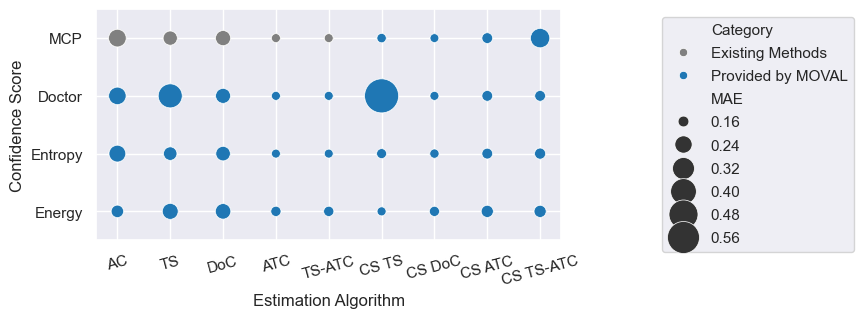

In [38]:
sns.set(rc={'figure.figsize':(6,3)})
sns.set_style("darkgrid")
category_palette = {'Existing Methods': 'grey', 'Provided by MOVAL': '#1f77b4'}
ax = sns.scatterplot(
    data=df, x="Estimation Algorithm", y="Confidence Score", hue="Category", size="MAE",
    sizes=(40, 600), palette=category_palette
)
ax.set(ylim=(3.5, -0.5))
ax.tick_params(axis='x', rotation=15)
#
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.2, 1), labelspacing = 0.6)
# Increase the line spacing by adjusting position

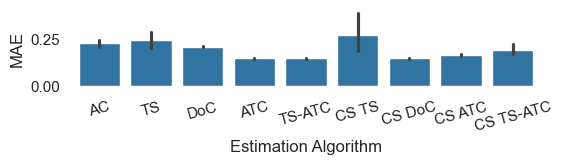

In [39]:
sns.set(rc={'figure.figsize':(6,1)})
sns.set_style("white")
ax = sns.barplot(df, x="Estimation Algorithm", y="MAE", color = '#1f77b4')
ax.tick_params(axis='x', rotation=15)
#
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')

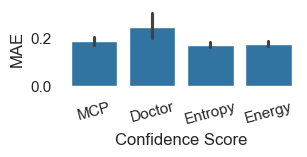

In [40]:
sns.set(rc={'figure.figsize':(3,1)})
sns.set_style("white")
ax = sns.barplot(df, x="Confidence Score", y="MAE", color = '#1f77b4')
ax.tick_params(axis='x', rotation=15)
#
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')

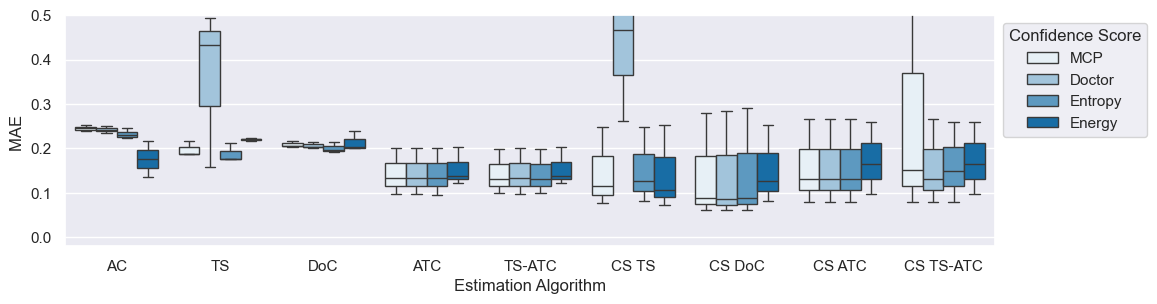

In [42]:
sns.set(rc={'figure.figsize':(12,3)})
category_palette = {'MCP': '#e5f0f8',
                    'Doctor': '#99c6e4',
                    'Entropy': '#4c9cd0',
                    'Energy': '#0072bd'
                   }
ax = sns.boxplot(df, x="Estimation Algorithm", y="MAE ", hue="Confidence Score", palette=category_palette)
ax.set(ylim=(-0.02, 0.5))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))